In [1]:
import sys

sys.path.append('../utils')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional
from typing import Union, List
from utils import check_index, adjacencyplot
from os.path import join as pjoin
import itertools
import scipy.spatial as spatial
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [3]:
from utils import filter_synapse_table, add_distance_columns, create_pairs_df

In [4]:
data_dir = '/Users/rodrigo.gonzalezlaiz/Desktop/v1dd_1196'
mat_version = '1196'

In [5]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy"))
axon_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

# get the ids of all proofread cells with both axon and dendrite proofreading
proof_root_ids = axon_proof_root_ids[np.isin(axon_proof_root_ids,
                                             dendrite_proof_root_ids)]

print(
    f"There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading"
)
print(
    f"The number of cells with usable axons and dendrites is: {len(proof_root_ids)}"
)


There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1148


In [6]:
cell_df = pd.read_feather(
    f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.

In [7]:
# note (rodrigo): in the workshop they only use the axon proofread cells (1164 cells)
cell_df_proofread = cell_df[
    np.isin(cell_df['pt_root_id'], axon_proof_root_ids) &
    np.isin(cell_df['pt_root_id'], dendrite_proof_root_ids)].reset_index(
        drop=True)

cell_axon_proofread_df = cell_df[np.isin(cell_df['pt_root_id'],
                                         axon_proof_root_ids)]

cell_dendrite_proofread_df = cell_df[np.isin(cell_df['pt_root_id'],
                                             dendrite_proof_root_ids)]
# cell_df_proofread_l3 = cell_df_proofread[cell_df_proofread["cell_type"] ==
#                                          "L3-IT"]

In [8]:
#NOTE(Rodrigo): proof_root_ids contains both "presynaptic" and "postsynaptic" root ids.
# only use synapses with proofread cells

syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

dendrite_proofread_syn_df = pd.read_feather(
    f"{data_dir}/syn_df_dendrite_and_coregistered_{mat_version}.feather")


In [9]:
coregistered_info = pd.read_feather(f"{data_dir}/coregistration_1196.feather")

## Simulate having random cells defined as choroist and soloist cells

In [32]:
dir_ = '/Users/rodrigo.gonzalezlaiz/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/projects/funcky_ensembles/Functional_Connectivity_V1DD/metadata/'

In [40]:
choroist_vs_soloists_df_vol5 = pd.read_csv(pjoin(dir_,
                                                 'volume5_cell_class.csv'))

choroist_vs_soloists_df_vol5['volume'] = 5
choroist_vs_soloists_df_vol3 = pd.read_csv(pjoin(dir_,
                                                 'volume3_cell_class.csv'))
choroist_vs_soloists_df_vol3['volume'] = 3

choroist_vs_soloists_df = pd.concat(
    [choroist_vs_soloists_df_vol5, choroist_vs_soloists_df_vol3])

# Shuffle the cell_class column to randomize choroist vs soloist assignments
choroist_vs_soloists_df['cell_class_random'] = choroist_vs_soloists_df[
    'cell_class'].sample(frac=1, random_state=42).reset_index(drop=True)


In [42]:
choroist_vs_soloists_df.shape

(10656, 7)

In [43]:
choroist_vs_soloists_df.rename(columns={
    'plane_ids': 'plane',
    'roi_ids': 'roi'
},
                               inplace=True)

coregistered_info_with_coupling = coregistered_info.merge(
    choroist_vs_soloists_df, on=['plane', 'roi'], how='left')


In [44]:
coregistered_info_with_coupling.head()

,pt_root_id,column,volume_x,plane,roi,cell_class,p_coupling_value,stimulus,volume_y,cell_class_random
0,864691132830842994,1,3,0,143,NaN,0.316052,p_coupling_drifting_gratings_full,3.0,NaN
1,864691132830842994,1,3,0,143,NaN,0.233745,p_coupling_natural_movies,3.0,NaN
2,864691132830842994,1,3,0,143,NaN,0.186731,p_coupling_spontaneous,3.0,NaN
3,864691132741466457,1,3,2,40,0.0,0.380468,p_coupling_drifting_gratings_full,5.0,NaN
4,864691132741466457,1,3,2,40,0.0,0.309256,p_coupling_natural_movies,5.0,1.0


In [45]:
dendrite_proofread_syn_df.shape

(2017256, 13)

In [46]:
cell_dendrite_proofread_df

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type
2,203262,624.680,531.094,283.770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT
3,350562,894.573,478.559,163.530,20.989259,117.514626,-98.554035,864691132773514104,326.965400,E,L2-IT
7,279097,735.493,568.808,331.110,-145.684124,252.802772,62.734671,864691132712267333,395.267333,None,None
10,367611,986.529,653.935,215.865,98.861884,303.237294,-68.777223,864691132777373560,238.028400,E,L4-IT
14,29289,382.180,438.285,70.605,-490.515829,54.880539,-191.187810,864691132997081013,417.215293,None,None
...,...,...,...,...,...,...,...,...,...,...,...
207442,546314,1313.846,949.281,259.290,330.518476,617.315862,-132.311505,864691132923394594,363.447329,E,L6-IT
207443,48131,349.976,576.102,285.435,-530.797586,249.491738,16.286294,864691132739246420,258.301980,E,L4-IT
207446,591233,1433.660,685.286,71.145,547.592388,292.362112,-216.663361,864691132899085806,231.127915,E,L4-IT
207448,267622,847.392,420.980,388.980,-26.457117,122.776379,135.307909,864691133046970980,349.824934,E,L2-IT


In [47]:
inputs_and_synapses_per_cell_coregistered = dendrite_proofread_syn_df.groupby(
    'post_pt_root_id').agg({
        'pre_pt_root_id': 'nunique',
        'post_pt_root_id': 'size',
        'size': 'sum'
    }).rename(
        columns={
            'pre_pt_root_id': 'inputs_per_cell',
            'post_pt_root_id': 'synapses_per_cell',
            'size': 'synapse_strength_per_cell'
        }).reset_index()

In [48]:
print(
    f"Mean - Inputs per cell: {inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].mean():.2f}, "
    f"Synapses per cell: {inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].mean():.2f}, "
    f"Synapse strength per cell: {inputs_and_synapses_per_cell_coregistered['synapse_strength_per_cell'].mean():.2f}"
)

print(
    f"Median - Inputs per cell: {inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].median():.2f}, "
    f"Synapses per cell: {inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].median():.2f}, "
    f"Synapse strength per cell: {inputs_and_synapses_per_cell_coregistered['synapse_strength_per_cell'].median():.2f}",
)
print(
    f"Max - Inputs per cell: {inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].max()}, "
    f"Synapses per cell: {inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].max()}, "
    f"Synapse strength per cell: {inputs_and_synapses_per_cell_coregistered['synapse_strength_per_cell'].max():.2f}"
)
print(
    f"Min - Inputs per cell: {inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].min()}, "
    f"Synapses per cell: {inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].min()}, "
    f"Synapse strength per cell: {inputs_and_synapses_per_cell_coregistered['synapse_strength_per_cell'].min():.2f}"
)

Mean - Inputs per cell: 3515.71, Synapses per cell: 3901.85, Synapse strength per cell: 6640500.37
Median - Inputs per cell: 2768.00, Synapses per cell: 2977.00, Synapse strength per cell: 5060279.00
Max - Inputs per cell: 12465, Synapses per cell: 14349, Synapse strength per cell: 25798068.00
Min - Inputs per cell: 433, Synapses per cell: 454, Synapse strength per cell: 431567.00


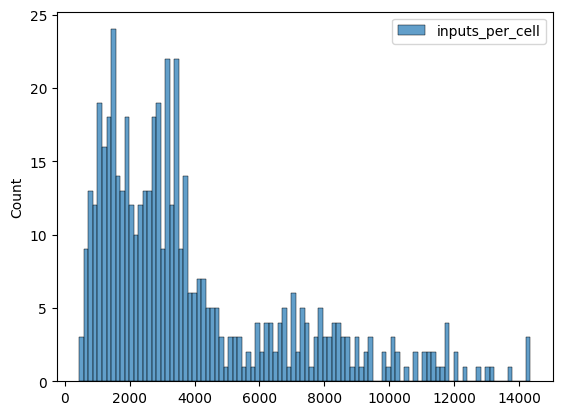

In [49]:
x = inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].values
y = inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].values
sns.histplot(y, bins=100, alpha=0.7, label='inputs_per_cell')
#sns.histplot(y, bins=1000, alpha=0.7, label='synapses_per_cell')
#plt.xlim(0, 1000)
plt.legend()
plt.show()

In [50]:
# syn_label_path = (
#     f"{data_dir}/syn_label_df_all_to_proofread_to_all_{mat_version}.feather")
# syn_label_df = pd.read_feather(syn_label_path)
# syn_label_df.head()


/var/folders/zh/r3ys8n591255r84b26zk70640000gn/T/ipykernel_59907/200431787.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


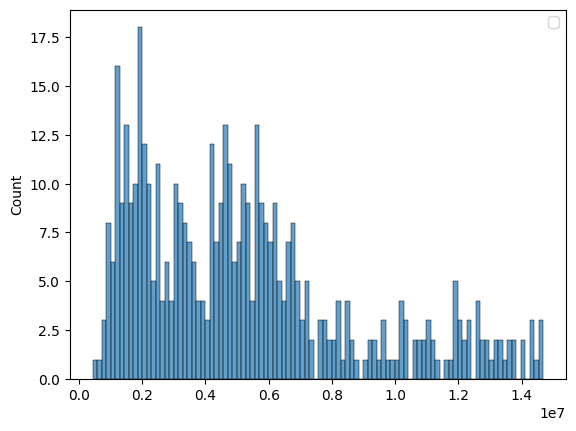

In [51]:
x = inputs_and_synapses_per_cell_coregistered[
    'synapse_strength_per_cell'].values

# Sample only the top 95th percentile to focus on high synapse strength cells
percentile_threshold = np.percentile(x, 90)
x = x[x <= percentile_threshold]

sns.histplot(x, bins=100, alpha=0.7)
#plt.xlim(0, 200)
plt.legend()
plt.show()


In [58]:
coregisterd_with_coupling_and_inputs_per_cell = coregistered_info_with_coupling.merge(
    inputs_and_synapses_per_cell_coregistered,
    left_on='pt_root_id',
    right_on='post_pt_root_id',
    how='left')

## logistic regression modeling 

In [59]:
df = coregisterd_with_coupling_and_inputs_per_cell.copy()

In [60]:
df['stimulus'].value_counts()

stimulus
p_coupling_drifting_gratings_full    933
p_coupling_natural_movies            933
p_coupling_spontaneous               933
Name: count, dtype: int64

In [61]:
df.head()

,pt_root_id,column,volume_x,plane,roi,cell_class,p_coupling_value,stimulus,volume_y,cell_class_random,post_pt_root_id,inputs_per_cell,synapses_per_cell,synapse_strength_per_cell
0,864691132830842994,1,3,0,143,NaN,0.316052,p_coupling_drifting_gratings_full,3.0,NaN,8.646911e+17,3796.0,4093.0,7207650.0
1,864691132830842994,1,3,0,143,NaN,0.233745,p_coupling_natural_movies,3.0,NaN,8.646911e+17,3796.0,4093.0,7207650.0
2,864691132830842994,1,3,0,143,NaN,0.186731,p_coupling_spontaneous,3.0,NaN,8.646911e+17,3796.0,4093.0,7207650.0
3,864691132741466457,1,3,2,40,0.0,0.380468,p_coupling_drifting_gratings_full,5.0,NaN,8.646911e+17,1535.0,1685.0,2649794.0
4,864691132741466457,1,3,2,40,0.0,0.309256,p_coupling_natural_movies,5.0,1.0,8.646911e+17,1535.0,1685.0,2649794.0


In [62]:
stimulus = 'p_coupling_spontaneous'
#stimulus = 'p_coupling_drifting_gratings_full'
#stimulus = 'p_coupling_natural_movies'

#x_variable = 'synapse_strength_per_cell'
x_variable = 'inputs_per_cell'
df_stimulus = df[df['stimulus'] == stimulus]

# df_stimulus_choroist = df_stimulus[df_stimulus['cell_class'] == 0.0]
# df_stimulus_soloist = df_stimulus[df_stimulus['cell_class'] == 1.0]

In [63]:
# they gave only synapses with proofread axons

# but we want to use synapses with proofread dendrites.


In [64]:
# Remove rows with NaN values in inputs_per_cell
df_stimulus = df_stimulus.dropna(subset=[x_variable])
df_stimulus_choroist = df_stimulus[df_stimulus['cell_class'] == 0.0]
df_stimulus_soloist = df_stimulus[df_stimulus['cell_class'] == 1.0]

print(f"After removing NaN values in inputs_per_cell:")
print(f"Total rows: {len(df_stimulus)}")
print(f"Choroist rows: {len(df_stimulus_choroist)}")
print(f"Soloist rows: {len(df_stimulus_soloist)}")
# Take first 30% of data based on row count, not value percentile

# Sort by x_variable and take the smallest 30%
# df_stimulus = df_stimulus.sort_values(x_variable)
# n_rows_to_keep = int(len(df_stimulus) * 1)
# df_stimulus = df_stimulus.head(n_rows_to_keep)

# print(f"After removing rows with inputs_per_cell > {percentile_threshold}:")
# print(f"Choroist rows: {len(df_stimulus_choroist)}")
# print(f"Soloist rows: {len(df_stimulus_soloist)}")


After removing NaN values in inputs_per_cell:
Total rows: 866
Choroist rows: 154
Soloist rows: 105


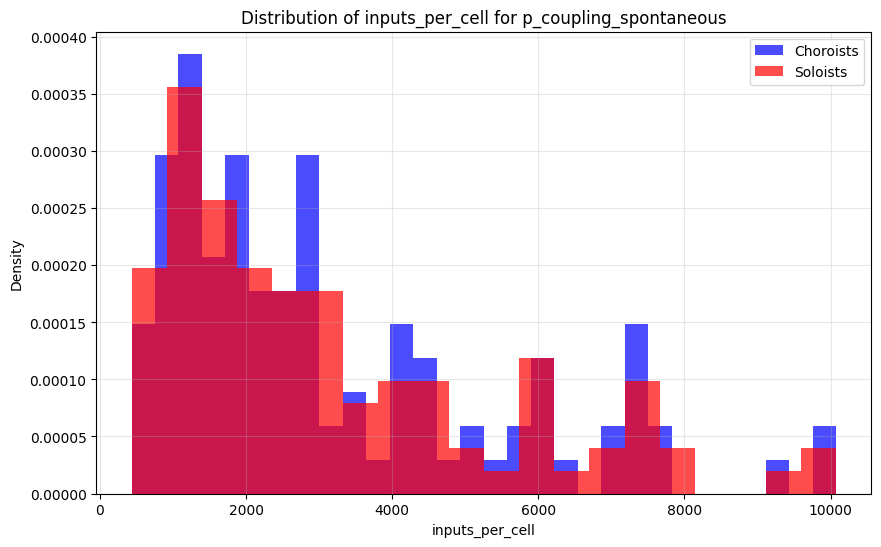

In [65]:
y_soloist = df_stimulus_soloist['p_coupling_value'].values
X_soloist = df_stimulus_soloist[x_variable].values

y_choroist = df_stimulus_choroist['p_coupling_value'].values
X_choroist = df_stimulus_choroist[x_variable].values

plt.figure(figsize=(10, 6))
plt.hist(X_soloist,
         bins=30,
         alpha=0.7,
         label='Choroists',
         color='blue',
         density=True)
plt.hist(X_soloist,
         bins=20,
         alpha=0.7,
         label='Soloists',
         color='red',
         density=True)
plt.xlabel(x_variable)
plt.ylabel('Density')
plt.title(f'Distribution of {x_variable} for {stimulus}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Soloists - R²: 0.0168, Coefficient: -0.000003
Choroists - R²: 0.0004, Coefficient: 0.000000


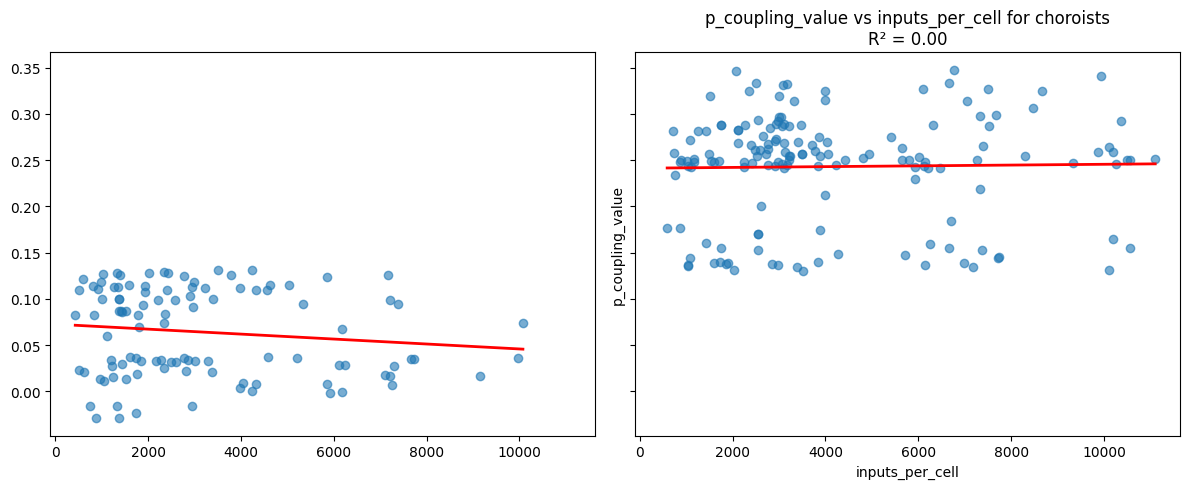

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

# Soloists plot
y_soloist = df_stimulus_soloist['p_coupling_value'].values
X_soloist = df_stimulus_soloist[x_variable].values

ax1.scatter(X_soloist, y_soloist, alpha=0.6)

# Linear regression for soloists
lr_soloist = LinearRegression()
lr_soloist.fit(X_soloist.reshape(-1, 1), y_soloist)
y_pred_soloist = lr_soloist.predict(X_soloist.reshape(-1, 1))
r2_soloist = r2_score(y_soloist, y_pred_soloist)
coef_soloist = lr_soloist.coef_[0]

# Plot regression line
x_range = np.linspace(np.nanmin(X_soloist), np.nanmax(X_soloist), 100)
y_range = lr_soloist.predict(x_range.reshape(-1, 1))
ax1.plot(x_range, y_range, 'r-', linewidth=2)

print(f"Soloists - R²: {r2_soloist:.4f}, Coefficient: {coef_soloist:.6f}")

ax2.set_xlabel(x_variable)
ax2.set_ylabel('p_coupling_value')
ax2.set_title(
    f'p_coupling_value vs {x_variable} for soloists\nR² = {r2_soloist:.2f}')
#ax1.set_xlim(0, 300)

# Choroists plot
y_choroist = df_stimulus_choroist['p_coupling_value'].values
X_choroist = df_stimulus_choroist[x_variable].values

ax2.scatter(X_choroist, y_choroist, alpha=0.6)

# Linear regression for choroists
lr_choroist = LinearRegression()
lr_choroist.fit(X_choroist.reshape(-1, 1), y_choroist)
y_pred_choroist = lr_choroist.predict(X_choroist.reshape(-1, 1))
r2_choroist = r2_score(y_choroist, y_pred_choroist)
coef_choroist = lr_choroist.coef_[0]

# Plot regression line
x_range = np.linspace(np.nanmin(X_choroist), np.nanmax(X_choroist), 100)
y_range = lr_choroist.predict(x_range.reshape(-1, 1))
ax2.plot(x_range, y_range, 'r-', linewidth=2)

print(f"Choroists - R²: {r2_choroist:.4f}, Coefficient: {coef_choroist:.6f}")

ax2.set_xlabel(x_variable)
ax2.set_ylabel('p_coupling_value')
ax2.set_title(
    f'p_coupling_value vs {x_variable} for choroists\nR² = {r2_choroist:.2f}')
#ax2.set_xlim(0, 300)

plt.tight_layout()

## distance between soloist and choroist cells

In [67]:
coregistered_df = coregistered_info_with_coupling.merge(cell_df,
                                                        on='pt_root_id',
                                                        how='left')

coregistered_df = coregistered_df[coregistered_df['stimulus'] ==
                                  'p_coupling_spontaneous']
coregistered_df = coregistered_df[coregistered_df['cell_class'].isin([0, 1])]


In [68]:
coregistered_df_pairs = create_pairs_df(coregistered_df)
coregistered_df_pairs = add_distance_columns(coregistered_df_pairs,
                                             distance_type='3d',
                                             use_transform=True)

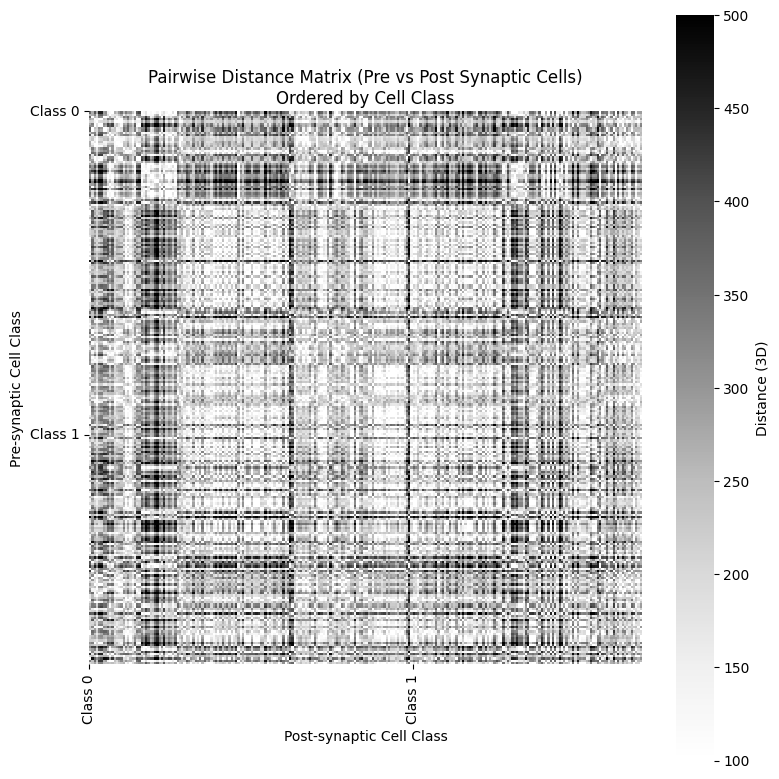

In [69]:
# Create a pivot table to show pairwise distances in matrix form
# Each unique pre_pt_root_id becomes a row, each unique post_pt_root_id becomes a column
distance_matrix = coregistered_df_pairs.pivot_table(
    index='pre_pt_root_id',
    columns='post_pt_root_id',
    values='distance_3d',
    aggfunc='mean'  # In case there are duplicates, take the mean
)

# Sort the index and columns by cell class
# First, create mappings from pt_root_id to cell_class for ordering
pre_cell_class_mapping = coregistered_df_pairs.drop_duplicates(
    'pre_pt_root_id').set_index(
        'pre_pt_root_id')['pre_cell_class'].sort_values()
post_cell_class_mapping = coregistered_df_pairs.drop_duplicates(
    'post_pt_root_id').set_index(
        'post_pt_root_id')['post_cell_class'].sort_values()

# Reorder the distance matrix by cell class
distance_matrix = distance_matrix.reindex(index=pre_cell_class_mapping.index,
                                          columns=post_cell_class_mapping.index)

# Plot the distance matrix as a heatmap
plt.figure(figsize=(8, 8))
ax = sns.heatmap(distance_matrix,
                 cmap='Greys',
                 square=True,
                 vmin=100,
                 vmax=500,
                 cbar_kws={'label': 'Distance (3D)'})
# # Replace tick labels with cell class values - show only one label per class
unique_pre_classes = pre_cell_class_mapping.unique()
unique_post_classes = post_cell_class_mapping.unique()

# Create simplified tick labels showing only unique classes
y_tick_positions = []
y_tick_labels = []
for class_val in sorted(unique_pre_classes):
    # Find the first occurrence of this class in the index
    first_idx = pre_cell_class_mapping[pre_cell_class_mapping ==
                                       class_val].index[0]
    position = list(distance_matrix.index).index(first_idx)
    y_tick_positions.append(position)
    y_tick_labels.append(f'Class {int(class_val)}')

ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels)

x_tick_positions = []
x_tick_labels = []
for class_val in sorted(unique_post_classes):
    # Find the first occurrence of this class in the columns
    first_idx = post_cell_class_mapping[post_cell_class_mapping ==
                                        class_val].index[0]
    position = list(distance_matrix.columns).index(first_idx)
    x_tick_positions.append(position)
    x_tick_labels.append(f'Class {int(class_val)}')

ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels)

plt.title(
    'Pairwise Distance Matrix (Pre vs Post Synaptic Cells)\nOrdered by Cell Class'
)
plt.xlabel('Post-synaptic Cell Class')
plt.ylabel('Pre-synaptic Cell Class')
plt.tight_layout()
plt.show()

In [95]:
len([
    f'Class {int(pre_cell_class_mapping[idx])}' for idx in distance_matrix.index
])

93

In [93]:
 distance_matrix.index

Index([864691132829082994, 864691132769042981, 864691132827234195,
       864691132761802292, 864691132904196228, 864691132853021758,
       864691132821823487, 864691132784991372, 864691132607930648,
       864691132830577529, 864691132725346673, 864691132920992737,
       864691132754592803, 864691132958325457, 864691132900289018,
       864691133043659040, 864691132639380575, 864691132742211262,
       864691132986775136, 864691132611195515, 864691132740201667,
       864691132720211882, 864691132709485099, 864691132802026717,
       864691133012940240, 864691132683860551, 864691132642306174,
       864691132770278268, 864691132819238416, 864691132695600105,
       864691132986155872, 864691132657125830, 864691132849698003,
       864691132834480292, 864691132778956491, 864691132689023370,
       864691133066905049, 864691132786775634, 864691132666786211,
       864691132624509644, 864691132608140569, 864691132730768955,
       864691132669608977, 864691132788008650, 864691132951373

In [83]:
coregistered_df_pairs.head()

,pre_pt_root_id,pre_column,pre_volume_x,pre_plane,pre_roi,pre_cell_class,pre_p_coupling_value,pre_stimulus,pre_id,pre_pt_position_x,...,post_pt_position_x,post_pt_position_y,post_pt_position_z,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,post_volume_y,post_cell_type_coarse,post_cell_type,distance_3d
0,864691132741466457,1,3,2,40,NaN,0.103125,p_coupling_spontaneous,276433,740.071,...,927.553,616.377,287.280,42.142603,286.280855,9.472949,275.509430,E,L3-IT,202.238022
1,864691132741466457,1,3,2,40,NaN,0.103125,p_coupling_spontaneous,276433,740.071,...,927.553,616.377,287.280,42.142603,286.280855,9.472949,275.509430,E,L3-IT,202.238022
2,864691132741466457,1,3,2,40,NaN,0.103125,p_coupling_spontaneous,276433,740.071,...,897.832,551.658,344.025,18.165122,238.797609,78.834508,245.712828,E,L3-IT,219.929810
3,864691132741466457,1,3,2,40,NaN,0.103125,p_coupling_spontaneous,276433,740.071,...,834.898,578.974,258.390,-45.089154,242.540718,-10.720569,329.847534,E,L3-IT,115.225268
4,864691132741466457,1,3,2,40,NaN,0.103125,p_coupling_spontaneous,276433,740.071,...,757.531,605.901,253.890,-125.447050,267.907975,-20.767301,325.774175,E,L3-IT,52.601518


In [82]:
coregistered_df_pairs['cell_class'] == 0

KeyError: 'cell_class'